In [118]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
import h5py
import numpy as np
import json
import gc
import sys
import os
import copy
from typing import List, Dict, Optional, Tuple
from sklearn.model_selection import train_test_split
import pandas as pd 
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

In [119]:
# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("✅ Libraries imported successfully")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

✅ Libraries imported successfully
PyTorch version: 2.8.0+cu129
CUDA available: True
CUDA device: NVIDIA GeForce RTX 5070 Ti


In [146]:
FILE_PATH = "C:\\workarea\\CNN model\\dataset\\radioml2018\\versions\\2\\GOLD_XYZ_OSC.0001_1024.hdf5"
JSON_PATH = 'C:\\workarea\\CNN model\\dataset\\radioml2018\\versions\\2\\classes-fixed.json' 
BATCH_SIZE = 256  # Adjust based on your GPU memory
NUM_WORKERS = 0  # Adjust based on your CPU cores
patience = 10
TARGET_MODULATIONS = [
    'OOK',
    '4ASK',
    '8ASK',
    'BPSK',
    'QPSK',
    '8PSK',
    '16PSK',
    '32PSK',
    '16APSK',
    '32APSK',
    '64APSK',
    '128APSK',
    '16QAM',
    '32QAM',
    '64QAM',
    '128QAM',
    '256QAM',
    'GMSK',
    'OQPSK'
]
NUM_CLASSES = len(TARGET_MODULATIONS)
NUM_EPOCHS = 300
SUBSAMPLE_TRAIN_RATIO = 1.0  # Use 20% of training data (set to 1.0 for full data)
TRAIN_SIZE = 0.7
VALID_SIZE = 0.2
TEST_SIZE = 0.1
SPLIT_SEED = 48
NORM_SEED = 49
CHUNK_SIZE = 10000 

# --- Parameter Model (Baru) ---
PATCH_SIZE = 4       # Ukuran patch (misal: 4x4)
D_MODEL = 256        # Dimensi embedding
N_HEAD = 16         # Jumlah attention heads
N_LAYERS = 6         # Jumlah lapisan encoder
FFN_HIDDEN = D_MODEL * 4 # Ukuran hidden layer di FFN
DROP_PROB = 0.15      # Dropout probability
LEARNING_RATE = 1e-4

In [147]:
# --- Path Setup ---
# Asumsikan notebook ini ada di /home/lipplopp/research/AMC_Repository/transformer/
# Kita tambahkan parent directory-nya ('transformer') ke path agar bisa mengimpor 'models'
notebook_dir = os.getcwd()
project_root = os.path.dirname(notebook_dir) # Seharusnya /home/lipplopp/research/AMC_Repository/
# Modul model ada di 'transformer/models'
model_path = os.path.join(notebook_dir, 'models') 
# Kita tambahkan directory 'transformer' ke path
if notebook_dir not in sys.path:
    sys.path.append(notebook_dir)
print(f"Menambahkan {notebook_dir} ke sys.path")

try:
    from models.amc_transformer import AMCTransformer
    print("✅ Modul AMCTransformer berhasil diimpor.")
except ImportError as e:
    print(f"❌ GAGAL mengimpor model: {e}")
    print("Pastikan notebook ini dijalankan dari dalam direktori 'transformer'!")

# --- Setup Device ---
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"🔧 Konfigurasi dimuat")
print(f"🎯 Target Modulasi: {TARGET_MODULATIONS} ({NUM_CLASSES} kelas)")
print(f"💾 Batch size: {BATCH_SIZE}")
print(f"🖥️ Device: {device}")

Menambahkan c:\workarea\CNN model\transformer ke sys.path
✅ Modul AMCTransformer berhasil diimpor.
🔧 Konfigurasi dimuat
🎯 Target Modulasi: ['OOK', '4ASK', '8ASK', 'BPSK', 'QPSK', '8PSK', '16PSK', '32PSK', '16APSK', '32APSK', '64APSK', '128APSK', '16QAM', '32QAM', '64QAM', '128QAM', '256QAM', 'GMSK', 'OQPSK'] (19 kelas)
💾 Batch size: 256
🖥️ Device: cuda


In [148]:
def load_dataset_metadata(file_path: str, json_path: str) -> Tuple[np.ndarray, np.ndarray, List[str], int]:
    """
    Load only metadata and labels from HDF5 file (memory efficient).
    
    Returns:
        (Y_strings, Z_data, available_modulations, total_samples)
    """
    print("📂 Loading dataset metadata (memory efficient)...")
    
    with h5py.File(file_path, 'r') as hdf5_file:
        # Get dataset shape without loading data
        total_samples = hdf5_file['X'].shape[0]
        signal_length = hdf5_file['X'].shape[1]
        num_channels = hdf5_file['X'].shape[2]
        
        print(f"📊 Dataset shape: ({total_samples:,} × {signal_length} × {num_channels})")
        
        # Load only labels (much smaller than signal data)
        Y_int = np.argmax(hdf5_file['Y'][:], axis=1)
        Z_data = hdf5_file['Z'][:, 0]
        
        # Load modulation classes
        with open(json_path, 'r') as f:
            modulation_classes = json.load(f)
        
        # Convert integer labels to string labels
        Y_strings = np.array([modulation_classes[i] for i in Y_int])
        
        # Get available modulations
        available_modulations = list(np.unique(Y_strings))
        
        print(f"✅ Metadata loaded: {total_samples:,} samples")
        print(f"📡 Available modulations: {len(available_modulations)}")
        print(f"📊 SNR range: {np.min(Z_data):.1f} to {np.max(Z_data):.1f} dB")
        
        # Memory usage estimate
        data_size_gb = (total_samples * signal_length * num_channels * 4) / (1024**3)
        print(f"💾 Full dataset size: ~{data_size_gb:.2f} GB")
        
    return Y_strings, Z_data, available_modulations, total_samples

In [149]:
def stratified_dataset_split_memory_efficient(
    modulations: np.ndarray, 
    snrs: np.ndarray, 
    target_modulations: List[str],
    train_size: float = 0.7, 
    valid_size: float = 0.2, 
    test_size: float = 0.1,
    seed: int = 48, 
    subsample_train_ratio: Optional[float] = None) -> Tuple[Dict, Dict]:
    """
    Memory-efficient stratified split (doesn't require loading X data).
    
    Args:
        modulations: Modulation labels (Y)
        snrs: SNR labels (Z)
        target_modulations: Modulations to include
        train_size, valid_size, test_size: Split proportions
        seed: Random seed
        subsample_train_ratio: Optional subsampling of training data
    
    Returns:
        (splits_dict, label_map)
    """
    
    # Input validation
    if not np.isclose(train_size + valid_size + test_size, 1.0, atol=1e-6):
        raise ValueError(f"Split sizes must sum to 1.0")
    
    if len(target_modulations) == 0:
        raise ValueError("target_modulations cannot be empty")
    
    print("🔄 Performing stratified split...")
    
    # Filter to include only target modulations
    target_mask = np.isin(modulations, target_modulations)
    target_indices = np.where(target_mask)[0]
    
    if len(target_indices) == 0:
        raise ValueError("No samples found for target modulations")
    
    print(f"📊 Found {len(target_indices):,} samples for target modulations")
    
    filtered_modulations = modulations[target_indices]
    filtered_snrs = snrs[target_indices]
    
    # Create stratification key
    stratify_key = [f"{mod}_{snr}" for mod, snr in zip(filtered_modulations, filtered_snrs)]
    
    # Check sample distribution
    unique_keys, key_counts = np.unique(stratify_key, return_counts=True)
    min_samples_per_key = np.min(key_counts)
    
    if min_samples_per_key < 2:
        warnings.warn(f"⚠️ Some modulation-SNR combinations have only {min_samples_per_key} samples.")
    
    # Set random seed
    np.random.seed(seed)
    
    # First split: separate test set
    train_val_indices, test_indices = train_test_split(
        target_indices, 
        test_size=test_size, 
        random_state=seed, 
        stratify=stratify_key
    )
    
    # Second split: separate train and validation
    remaining_modulations = modulations[train_val_indices]
    remaining_snrs = snrs[train_val_indices]
    remaining_stratify_key = [f"{mod}_{snr}" for mod, snr in zip(remaining_modulations, remaining_snrs)]
    
    relative_valid_size = valid_size / (1 - test_size)
    
    train_indices, valid_indices = train_test_split(
        train_val_indices,
        test_size=relative_valid_size,
        random_state=seed,
        stratify=remaining_stratify_key
    )
    
    # Apply subsampling if requested
    if subsample_train_ratio is not None and subsample_train_ratio < 1.0:
        n_keep = int(len(train_indices) * subsample_train_ratio)
        if n_keep == 0:
            raise ValueError("Subsampling ratio too small")
        
        np.random.seed(seed)
        train_indices = np.random.choice(train_indices, n_keep, replace=False)
        print(f"📉 Subsampled training data to {n_keep:,} samples ({subsample_train_ratio:.1%})")
    
    # Create label mapping
    label_map = {name: i for i, name in enumerate(target_modulations)}
    
    # Print statistics
    print(f"\n✅ Dataset split completed:")
    print(f"  📚 Train: {len(train_indices):,} samples")
    print(f"  🔍 Valid: {len(valid_indices):,} samples") 
    print(f"  🧪 Test: {len(test_indices):,} samples")
    
    splits = {
        'train': train_indices,
        'valid': valid_indices,
        'test': test_indices
    }
    
    return splits, label_map

print("✅ Memory-efficient functions defined")

✅ Memory-efficient functions defined


In [150]:
class SingleStreamImageDataset(Dataset):
    """
    Versi modifikasi dari dataset Anda.
    - Mengubah H, W menjadi 32, 64.
    - Menghapus perhitungan Amplitudo/Fase.
    - Menghasilkan satu 'gambar' I/Q gabungan ber-shape [1, 32, 64].
    """
    
    def __init__(self, 
                 file_path: str, 
                 json_path: str, 
                 target_modulations: List[str], 
                 mode: str, 
                 indices: np.ndarray, 
                 label_map: Dict[str, int], 
                 normalization_stats: Optional[Dict] = None, 
                 seed: int = 49):
        super(SingleStreamImageDataset, self).__init__()

        # Validasi
        if mode not in ['train', 'valid', 'test']:
            raise ValueError(f"mode must be 'train', 'valid', or 'test'")
        if len(indices) == 0:
            raise ValueError("indices cannot be empty")
            
        self.file_path = file_path
        self.json_path = json_path
        self.target_modulations = target_modulations
        self.mode = mode
        self.indices = np.array(indices, dtype=int)
        self.label_map = label_map
        self.seed = seed

        self.hdf5_file = h5py.File(self.file_path, 'r')
        self.X_h5 = self.hdf5_file['X']
        
        self.Y_int = np.argmax(self.hdf5_file['Y'][:], axis=1)
        self.Z = self.hdf5_file['Z'][:, 0]

        with open(self.json_path, 'r') as f:
            self.modulation_classes = json.load(f)

        self.Y_strings = np.array([self.modulation_classes[i] for i in self.Y_int])

        signal_length = self.X_h5.shape[1]
        if signal_length != 1024:
            raise ValueError(f"Expected signal length 1024, got {signal_length}")
        
        # --- PERUBAHAN DI SINI ---
        # 1024 (I) + 1024 (Q) = 2048. 32 * 64 = 2048.
        self.H, self.W = 32, 64

        if mode == 'train':
            if normalization_stats is None:
                print(f"📊 Menghitung statistik normalisasi untuk mode {mode}...")
                self.norm_stats = self._calculate_normalization_stats()
                print(f"✅ Statistik dihitung")
            else:
                self.norm_stats = normalization_stats
        else:
            if normalization_stats is None:
                raise ValueError(f"normalization_stats wajib ada untuk mode '{mode}'")
            self.norm_stats = normalization_stats

        print(f"✅ {mode.capitalize()} dataset: {len(self.indices):,} sampel (mode memori-efisien)")

    def _calculate_normalization_stats(self) -> Dict[str, float]:
        """Menghitung statistik normalisasi (hanya I/Q) menggunakan chunked processing."""
        num_samples = min(5000, len(self.indices))
        np.random.seed(self.seed)
        sample_indices = np.random.choice(self.indices, num_samples, replace=False)
        sorted_indices = np.sort(sample_indices)
        
        chunk_size = min(500, num_samples)
        i_vals, q_vals = [], []
        
        print(f"  Memproses {num_samples} sampel dalam {len(sorted_indices)//chunk_size + 1} chunk...")
        for i in range(0, len(sorted_indices), chunk_size):
            chunk_indices = sorted_indices[i:i+chunk_size]
            chunk_data = self.X_h5[chunk_indices, ...]
            chunk_tensor = torch.from_numpy(chunk_data).float()
            
            i_vals.append(chunk_tensor[:, :, 0].flatten())
            q_vals.append(chunk_tensor[:, :, 1].flatten())
            del chunk_data, chunk_tensor
        
        i_all = torch.cat(i_vals)
        q_all = torch.cat(q_vals)
        
        stats = {
            'i_mean': i_all.mean().item(),
            'i_std': max(i_all.std().item(), 1e-8),
            'q_mean': q_all.mean().item(), 
            'q_std': max(q_all.std().item(), 1e-8)
        }
        
        del i_vals, q_vals, i_all, q_all
        gc.collect()
        return stats

    def __len__(self) -> int:
        return len(self.indices)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int, float]:
        """Mendapatkan satu sampel sebagai 'gambar' I/Q gabungan."""
        if idx >= len(self.indices):
            raise IndexError(f"Index {idx} di luar jangkauan")
            
        true_index = int(self.indices[idx])
        
        x_raw = self.X_h5[true_index]
        y_string = self.Y_strings[true_index]
        z = float(self.Z[true_index])
        
        y = self.label_map[y_string]

        iq_sequence = torch.from_numpy(x_raw.copy()).float()
        iq_sequence[:, 0] = (iq_sequence[:, 0] - self.norm_stats['i_mean']) / self.norm_stats['i_std']
        iq_sequence[:, 1] = (iq_sequence[:, 1] - self.norm_stats['q_mean']) / self.norm_stats['q_std']

        # --- INTI PERUBAHAN ---
        # 1. Ambil sinyal I dan Q yang sudah dinormalisasi
        i_signal = iq_sequence[:, 0]
        q_signal = iq_sequence[:, 1]
        
        # 2. Gabungkan keduanya
        iq_concat = torch.cat((i_signal, q_signal), dim=0) # Shape: [2048]
        
        # 3. Ubah bentuknya menjadi "gambar" 2D (Channel, Height, Width)
        iq_image = iq_concat.view(1, self.H, self.W) # Shape: [1, 32, 64]
        # --- AKHIR PERUBAHAN ---
        
        return iq_image, y, z

    def get_normalization_stats(self) -> Dict[str, float]:
        return self.norm_stats.copy()

    def close(self):
        if hasattr(self, 'hdf5_file') and self.hdf5_file is not None:
            try:
                self.hdf5_file.close()
                print(f"🔒 {self.mode.capitalize()} dataset: File HDF5 ditutup")
            except: pass
            finally: self.hdf5_file = None

    def __del__(self):
        self.close()

print("✅ Kelas SingleStreamImageDataset didefinisikan.")

✅ Kelas SingleStreamImageDataset didefinisikan.


In [151]:
def split_data(file_path, json_path, target_mods, train_ratio, valid_ratio, test_ratio, seed):
    print("Membagi data...")
    if not np.isclose(train_ratio + valid_ratio + test_ratio, 1.0):
        raise ValueError("Rasio split harus berjumlah 1.0")
        
    # 1. Buat label_map dari target
    label_map = {mod: i for i, mod in enumerate(target_mods)}
    
    # 2. Muat semua label dan SNR
    with h5py.File(file_path, 'r') as f:
        Y_int = np.argmax(f['Y'][:], axis=1)
        Z = f['Z'][:, 0]
        
    with open(json_path, 'r') as file:
        all_mod_classes = json.load(file)
    
    Y_strings = np.array([all_mod_classes[i] for i in Y_int])
    
    train_indices, valid_indices, test_indices = [], [], []
    
    # 3. Stratifikasi berdasarkan Modulasi DAN SNR
    for mod in target_mods:
        for snr in np.unique(Z):
            # Dapatkan semua indeks untuk pasangan (mod, snr) ini
            idx = np.where((Y_strings == mod) & (Z == snr))[0]
            if len(idx) == 0:
                continue
            
            # Split pertama: pisahkan data Uji
            idx_train_val, idx_test = train_test_split(
                idx, test_size=test_ratio, random_state=seed, shuffle=True
            )
            
            # Hitung ulang rasio validasi untuk split kedua
            relative_valid_ratio = valid_ratio / (train_ratio + valid_ratio)
            
            # Split kedua: pisahkan data Latih dan Validasi
            if len(idx_train_val) > 1:
                idx_train, idx_valid = train_test_split(
                    idx_train_val, test_size=relative_valid_ratio, random_state=seed, shuffle=True
                )
            else: # Jika hanya tersisa 1 sampel, masukkan ke training
                idx_train, idx_valid = idx_train_val, []

            train_indices.extend(idx_train)
            valid_indices.extend(idx_valid)
            test_indices.extend(idx_test)
            
    # 4. Acak hasil akhir
    np.random.seed(seed)
    np.random.shuffle(train_indices)
    np.random.shuffle(valid_indices)
    np.random.shuffle(test_indices)
    
    print(f"Data terbagi: {len(train_indices)} Latih, {len(valid_indices)} Validasi, {len(test_indices)} Uji")
    return np.array(train_indices), np.array(valid_indices), np.array(test_indices), label_map

print("✅ Fungsi split_data didefinisikan.")

✅ Fungsi split_data didefinisikan.


In [152]:
# Jalankan pemisahan data
train_indices, valid_indices, test_indices, label_map = split_data(
    FILE_PATH, JSON_PATH, TARGET_MODULATIONS, TRAIN_SIZE, VALID_SIZE, TEST_SIZE, SPLIT_SEED
)

# 1. Buat dataset Latih dan dapatkan statistik normalisasi
train_dataset = SingleStreamImageDataset(
    file_path=FILE_PATH, json_path=JSON_PATH, target_modulations=TARGET_MODULATIONS,
    mode='train', indices=train_indices, label_map=label_map, seed=NORM_SEED
)
norm_stats = train_dataset.get_normalization_stats()
print(f"Statistik Normalisasi: {norm_stats}")

# 2. Buat dataset Validasi (menggunakan statistik dari Latih)
valid_dataset = SingleStreamImageDataset(
    file_path=FILE_PATH, json_path=JSON_PATH, target_modulations=TARGET_MODULATIONS,
    mode='valid', indices=valid_indices, label_map=label_map, normalization_stats=norm_stats
)

# 3. Buat dataset Uji (menggunakan statistik dari Latih)
test_dataset = SingleStreamImageDataset(
    file_path=FILE_PATH, json_path=JSON_PATH, target_modulations=TARGET_MODULATIONS,
    mode='test', indices=test_indices, label_map=label_map, normalization_stats=norm_stats
)

# 4. Buat DataLoaders
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
    num_workers=NUM_WORKERS, pin_memory=True
)
valid_loader = DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, shuffle=False, 
    num_workers=NUM_WORKERS, pin_memory=True
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
    num_workers=NUM_WORKERS, pin_memory=True
)

print("\n✅ DataLoaders siap.")

Membagi data...
Data terbagi: 1415804 Latih, 405080 Validasi, 202540 Uji
📊 Menghitung statistik normalisasi untuk mode train...
  Memproses 5000 sampel dalam 11 chunk...
✅ Statistik dihitung
✅ Train dataset: 1,415,804 sampel (mode memori-efisien)
Statistik Normalisasi: {'i_mean': -0.0006897609564475715, 'i_std': 0.7601448893547058, 'q_mean': 0.0031226903665810823, 'q_std': 0.7659090757369995}
✅ Valid dataset: 405,080 sampel (mode memori-efisien)
✅ Test dataset: 202,540 sampel (mode memori-efisien)
🔒 Valid dataset: File HDF5 ditutup
🔒 Test dataset: File HDF5 ditutup

✅ DataLoaders siap.


In [153]:
# Mari kita periksa satu batch
print("Melakukan sanity check pada DataLoader...")
try:
    images, labels, snrs = next(iter(train_loader))
    print(f"Shape batch gambar: {images.shape}")
    print(f"Shape batch label:  {labels.shape}")
    print(f"Contoh SNR:         {snrs[:5].tolist()}")
    
    # Harapannya [BATCH_SIZE, 1, 32, 64]
    assert images.shape == (BATCH_SIZE, 1, 32, 64) or images.shape[1:] == (1, 32, 64)
    print("✅ Sanity check berhasil!")
except Exception as e:
    print(f"❌ Sanity check GAGAL: {e}")

Melakukan sanity check pada DataLoader...
Shape batch gambar: torch.Size([256, 1, 32, 64])
Shape batch label:  torch.Size([256])
Contoh SNR:         [10.0, -8.0, -2.0, -12.0, 26.0]
✅ Sanity check berhasil!


In [154]:
print("Menginisialisasi model...")

# Tentukan parameter input untuk model
# (Berdasarkan `test_model.py` dan `patch_embedding.py`)
model_params = {
    'in_channels': 1,
    'img_size_h': 32,    # Tambahkan ini (dari dataset kita)
    'img_size_w': 64,    # Tambahkan ini (dari dataset kita)
    'patch_size': PATCH_SIZE,
    'num_classes': NUM_CLASSES,
    'd_model': D_MODEL,
    'n_head': N_HEAD,
    'n_layers': N_LAYERS,
    'ffn_hidden': FFN_HIDDEN,
    'drop_prob': DROP_PROB,
    'device': device
}

# Inisialisasi model
model = AMCTransformer(**model_params).to(device)

# Inisialisasi Loss dan Optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(
    model.parameters(), 
    lr = LEARNING_RATE,
    weight_decay=1e-3,
    betas=(0.9, 0.99)
)

# Variabel untuk Early Stopping
best_val_loss = float('inf')
patience_counter = 0
best_model_weights = None

# Riwayat untuk plotting
history = {
    'train_loss': [],
    'val_loss': [],
    'val_acc': []
}

print(f"✅ Model AMCTransformer diinisialisasi dengan {sum(p.numel() for p in model.parameters()):,} parameter.")

Menginisialisasi model...
✅ Model AMCTransformer diinisialisasi dengan 4,748,051 parameter.


In [155]:
print(summary(model))

Layer (type:depth-idx)                                       Param #
AMCTransformer                                               --
├─Encoder: 1-1                                               256
│    └─PatchEmbedding: 2-1                                   --
│    │    └─Conv2d: 3-1                                      4,352
│    └─PositionalEncoding: 2-2                               --
│    └─ModuleList: 2-3                                       --
│    │    └─EncoderLayer: 3-2                                789,760
│    │    └─EncoderLayer: 3-3                                789,760
│    │    └─EncoderLayer: 3-4                                789,760
│    │    └─EncoderLayer: 3-5                                789,760
│    │    └─EncoderLayer: 3-6                                789,760
│    │    └─EncoderLayer: 3-7                                789,760
│    └─Dropout: 2-4                                          --
├─Linear: 1-2                                                4,88

In [156]:
print("🚀 Memulai Training...")

for epoch in range(NUM_EPOCHS):
    print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
    
    # --- FASE TRAINING ---
    model.train()
    running_train_loss = 0.0
    
    # Gunakan tqdm untuk progress bar
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]", unit="batch")
    
    for images, labels, _ in train_pbar:
        images, labels = images.to(device), labels.to(device)
        
        # Nol-kan gradien
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass dan optimasi
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()
        train_pbar.set_postfix(loss=f"{loss.item():.4f}")
    
    epoch_train_loss = running_train_loss / len(train_loader)
    history['train_loss'].append(epoch_train_loss)
    print(f"Epoch {epoch+1} Selesai. Rata-rata Train Loss: {epoch_train_loss:.4f}")
    
    # --- FASE VALIDASI ---
    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0
    
    val_pbar = tqdm(valid_loader, desc=f"Epoch {epoch+1} [Valid]", unit="batch")
    
    with torch.no_grad():
        for images, labels, _ in val_pbar:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            
            # Hitung akurasi
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            val_pbar.set_postfix(loss=f"{loss.item():.4f}")

    epoch_val_loss = running_val_loss / len(valid_loader)
    epoch_val_acc = 100 * correct / total
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc)
    
    print(f"Rata-rata Valid Loss: {epoch_val_loss:.4f} | Valid Acc: {epoch_val_acc:.2f}%")
    
    # --- Cek Early Stopping ---
    if epoch_val_loss < best_val_loss:
        print(f"💡 Valid Loss membaik: {best_val_loss:.4f} -> {epoch_val_loss:.4f}. Menyimpan model...")
        best_val_loss = epoch_val_loss
        patience_counter = 0
        best_model_weights = copy.deepcopy(model.state_dict())
    else:
        patience_counter += 1
        print(f"⌛ Valid Loss tidak membaik. Kesabaran: {patience_counter}/{patience}")

    if patience_counter >= patience:
        print(f"🛑 Early stopping di epoch {epoch+1}.")
        break

print("\n🏁 Training Selesai.")
# Muat bobot model terbaik
if best_model_weights:
    print("Memuat bobot model terbaik untuk evaluasi...")
    model.load_state_dict(best_model_weights)

🚀 Memulai Training...

--- Epoch 1/300 ---


Epoch 1 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 1 Selesai. Rata-rata Train Loss: 2.3678


Epoch 1 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 2.2309 | Valid Acc: 28.42%
💡 Valid Loss membaik: inf -> 2.2309. Menyimpan model...

--- Epoch 2/300 ---


Epoch 2 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 2 Selesai. Rata-rata Train Loss: 2.1919


Epoch 2 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 2.1877 | Valid Acc: 30.28%
💡 Valid Loss membaik: 2.2309 -> 2.1877. Menyimpan model...

--- Epoch 3/300 ---


Epoch 3 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 3 Selesai. Rata-rata Train Loss: 2.1464


Epoch 3 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 2.1630 | Valid Acc: 31.05%
💡 Valid Loss membaik: 2.1877 -> 2.1630. Menyimpan model...

--- Epoch 4/300 ---


Epoch 4 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 4 Selesai. Rata-rata Train Loss: 2.1137


Epoch 4 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 2.1278 | Valid Acc: 33.22%
💡 Valid Loss membaik: 2.1630 -> 2.1278. Menyimpan model...

--- Epoch 5/300 ---


Epoch 5 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 5 Selesai. Rata-rata Train Loss: 2.0808


Epoch 5 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 2.0402 | Valid Acc: 36.46%
💡 Valid Loss membaik: 2.1278 -> 2.0402. Menyimpan model...

--- Epoch 6/300 ---


Epoch 6 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 6 Selesai. Rata-rata Train Loss: 2.0563


Epoch 6 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 2.0189 | Valid Acc: 37.44%
💡 Valid Loss membaik: 2.0402 -> 2.0189. Menyimpan model...

--- Epoch 7/300 ---


Epoch 7 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 7 Selesai. Rata-rata Train Loss: 2.0393


Epoch 7 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 2.0333 | Valid Acc: 36.73%
⌛ Valid Loss tidak membaik. Kesabaran: 1/10

--- Epoch 8/300 ---


Epoch 8 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 8 Selesai. Rata-rata Train Loss: 2.0269


Epoch 8 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 2.0098 | Valid Acc: 37.72%
💡 Valid Loss membaik: 2.0189 -> 2.0098. Menyimpan model...

--- Epoch 9/300 ---


Epoch 9 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 9 Selesai. Rata-rata Train Loss: 2.0166


Epoch 9 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.9866 | Valid Acc: 38.75%
💡 Valid Loss membaik: 2.0098 -> 1.9866. Menyimpan model...

--- Epoch 10/300 ---


Epoch 10 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 10 Selesai. Rata-rata Train Loss: 2.0076


Epoch 10 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 2.0004 | Valid Acc: 38.48%
⌛ Valid Loss tidak membaik. Kesabaran: 1/10

--- Epoch 11/300 ---


Epoch 11 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 11 Selesai. Rata-rata Train Loss: 1.9980


Epoch 11 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 2.0023 | Valid Acc: 38.27%
⌛ Valid Loss tidak membaik. Kesabaran: 2/10

--- Epoch 12/300 ---


Epoch 12 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 12 Selesai. Rata-rata Train Loss: 1.9847


Epoch 12 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.9577 | Valid Acc: 40.31%
💡 Valid Loss membaik: 1.9866 -> 1.9577. Menyimpan model...

--- Epoch 13/300 ---


Epoch 13 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 13 Selesai. Rata-rata Train Loss: 1.9741


Epoch 13 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.9529 | Valid Acc: 40.47%
💡 Valid Loss membaik: 1.9577 -> 1.9529. Menyimpan model...

--- Epoch 14/300 ---


Epoch 14 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 14 Selesai. Rata-rata Train Loss: 1.9647


Epoch 14 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.9635 | Valid Acc: 40.18%
⌛ Valid Loss tidak membaik. Kesabaran: 1/10

--- Epoch 15/300 ---


Epoch 15 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 15 Selesai. Rata-rata Train Loss: 1.9562


Epoch 15 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.9313 | Valid Acc: 41.35%
💡 Valid Loss membaik: 1.9529 -> 1.9313. Menyimpan model...

--- Epoch 16/300 ---


Epoch 16 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 16 Selesai. Rata-rata Train Loss: 1.9471


Epoch 16 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.9479 | Valid Acc: 41.11%
⌛ Valid Loss tidak membaik. Kesabaran: 1/10

--- Epoch 17/300 ---


Epoch 17 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 17 Selesai. Rata-rata Train Loss: 1.9342


Epoch 17 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.9057 | Valid Acc: 42.39%
💡 Valid Loss membaik: 1.9313 -> 1.9057. Menyimpan model...

--- Epoch 18/300 ---


Epoch 18 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 18 Selesai. Rata-rata Train Loss: 1.9131


Epoch 18 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.8917 | Valid Acc: 42.93%
💡 Valid Loss membaik: 1.9057 -> 1.8917. Menyimpan model...

--- Epoch 19/300 ---


Epoch 19 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 19 Selesai. Rata-rata Train Loss: 1.8851


Epoch 19 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.8430 | Valid Acc: 45.23%
💡 Valid Loss membaik: 1.8917 -> 1.8430. Menyimpan model...

--- Epoch 20/300 ---


Epoch 20 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 20 Selesai. Rata-rata Train Loss: 1.8518


Epoch 20 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.8002 | Valid Acc: 46.70%
💡 Valid Loss membaik: 1.8430 -> 1.8002. Menyimpan model...

--- Epoch 21/300 ---


Epoch 21 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 21 Selesai. Rata-rata Train Loss: 1.8236


Epoch 21 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.7609 | Valid Acc: 48.20%
💡 Valid Loss membaik: 1.8002 -> 1.7609. Menyimpan model...

--- Epoch 22/300 ---


Epoch 22 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 22 Selesai. Rata-rata Train Loss: 1.8036


Epoch 22 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.7471 | Valid Acc: 49.05%
💡 Valid Loss membaik: 1.7609 -> 1.7471. Menyimpan model...

--- Epoch 23/300 ---


Epoch 23 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 23 Selesai. Rata-rata Train Loss: 1.7886


Epoch 23 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.7402 | Valid Acc: 49.66%
💡 Valid Loss membaik: 1.7471 -> 1.7402. Menyimpan model...

--- Epoch 24/300 ---


Epoch 24 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 24 Selesai. Rata-rata Train Loss: 1.7763


Epoch 24 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.7232 | Valid Acc: 50.35%
💡 Valid Loss membaik: 1.7402 -> 1.7232. Menyimpan model...

--- Epoch 25/300 ---


Epoch 25 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 25 Selesai. Rata-rata Train Loss: 1.7662


Epoch 25 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.7304 | Valid Acc: 50.09%
⌛ Valid Loss tidak membaik. Kesabaran: 1/10

--- Epoch 26/300 ---


Epoch 26 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 26 Selesai. Rata-rata Train Loss: 1.7576


Epoch 26 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.7091 | Valid Acc: 51.01%
💡 Valid Loss membaik: 1.7232 -> 1.7091. Menyimpan model...

--- Epoch 27/300 ---


Epoch 27 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 27 Selesai. Rata-rata Train Loss: 1.7489


Epoch 27 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.7128 | Valid Acc: 50.56%
⌛ Valid Loss tidak membaik. Kesabaran: 1/10

--- Epoch 28/300 ---


Epoch 28 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 28 Selesai. Rata-rata Train Loss: 1.7407


Epoch 28 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.7009 | Valid Acc: 51.39%
💡 Valid Loss membaik: 1.7091 -> 1.7009. Menyimpan model...

--- Epoch 29/300 ---


Epoch 29 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 29 Selesai. Rata-rata Train Loss: 1.7334


Epoch 29 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.7249 | Valid Acc: 51.01%
⌛ Valid Loss tidak membaik. Kesabaran: 1/10

--- Epoch 30/300 ---


Epoch 30 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 30 Selesai. Rata-rata Train Loss: 1.7262


Epoch 30 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.6855 | Valid Acc: 52.09%
💡 Valid Loss membaik: 1.7009 -> 1.6855. Menyimpan model...

--- Epoch 31/300 ---


Epoch 31 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 31 Selesai. Rata-rata Train Loss: 1.7182


Epoch 31 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.6840 | Valid Acc: 52.89%
💡 Valid Loss membaik: 1.6855 -> 1.6840. Menyimpan model...

--- Epoch 32/300 ---


Epoch 32 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 32 Selesai. Rata-rata Train Loss: 1.7107


Epoch 32 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.6957 | Valid Acc: 52.47%
⌛ Valid Loss tidak membaik. Kesabaran: 1/10

--- Epoch 33/300 ---


Epoch 33 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 33 Selesai. Rata-rata Train Loss: 1.7034


Epoch 33 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.6731 | Valid Acc: 53.28%
💡 Valid Loss membaik: 1.6840 -> 1.6731. Menyimpan model...

--- Epoch 34/300 ---


Epoch 34 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 34 Selesai. Rata-rata Train Loss: 1.6968


Epoch 34 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.6689 | Valid Acc: 53.76%
💡 Valid Loss membaik: 1.6731 -> 1.6689. Menyimpan model...

--- Epoch 35/300 ---


Epoch 35 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 35 Selesai. Rata-rata Train Loss: 1.6904


Epoch 35 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.6616 | Valid Acc: 54.21%
💡 Valid Loss membaik: 1.6689 -> 1.6616. Menyimpan model...

--- Epoch 36/300 ---


Epoch 36 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 36 Selesai. Rata-rata Train Loss: 1.6837


Epoch 36 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.6658 | Valid Acc: 54.16%
⌛ Valid Loss tidak membaik. Kesabaran: 1/10

--- Epoch 37/300 ---


Epoch 37 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 37 Selesai. Rata-rata Train Loss: 1.6784


Epoch 37 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.6545 | Valid Acc: 54.72%
💡 Valid Loss membaik: 1.6616 -> 1.6545. Menyimpan model...

--- Epoch 38/300 ---


Epoch 38 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 38 Selesai. Rata-rata Train Loss: 1.6715


Epoch 38 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.6360 | Valid Acc: 55.37%
💡 Valid Loss membaik: 1.6545 -> 1.6360. Menyimpan model...

--- Epoch 39/300 ---


Epoch 39 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 39 Selesai. Rata-rata Train Loss: 1.6638


Epoch 39 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.6291 | Valid Acc: 55.56%
💡 Valid Loss membaik: 1.6360 -> 1.6291. Menyimpan model...

--- Epoch 40/300 ---


Epoch 40 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 40 Selesai. Rata-rata Train Loss: 1.6572


Epoch 40 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.6370 | Valid Acc: 55.38%
⌛ Valid Loss tidak membaik. Kesabaran: 1/10

--- Epoch 41/300 ---


Epoch 41 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 41 Selesai. Rata-rata Train Loss: 1.6512


Epoch 41 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.6188 | Valid Acc: 56.13%
💡 Valid Loss membaik: 1.6291 -> 1.6188. Menyimpan model...

--- Epoch 42/300 ---


Epoch 42 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 42 Selesai. Rata-rata Train Loss: 1.6458


Epoch 42 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.6145 | Valid Acc: 56.48%
💡 Valid Loss membaik: 1.6188 -> 1.6145. Menyimpan model...

--- Epoch 43/300 ---


Epoch 43 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 43 Selesai. Rata-rata Train Loss: 1.6408


Epoch 43 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.6095 | Valid Acc: 56.58%
💡 Valid Loss membaik: 1.6145 -> 1.6095. Menyimpan model...

--- Epoch 44/300 ---


Epoch 44 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 44 Selesai. Rata-rata Train Loss: 1.6358


Epoch 44 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.6115 | Valid Acc: 56.74%
⌛ Valid Loss tidak membaik. Kesabaran: 1/10

--- Epoch 45/300 ---


Epoch 45 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 45 Selesai. Rata-rata Train Loss: 1.6307


Epoch 45 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.6016 | Valid Acc: 56.92%
💡 Valid Loss membaik: 1.6095 -> 1.6016. Menyimpan model...

--- Epoch 46/300 ---


Epoch 46 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 46 Selesai. Rata-rata Train Loss: 1.6258


Epoch 46 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.5991 | Valid Acc: 57.10%
💡 Valid Loss membaik: 1.6016 -> 1.5991. Menyimpan model...

--- Epoch 47/300 ---


Epoch 47 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 47 Selesai. Rata-rata Train Loss: 1.6216


Epoch 47 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.6010 | Valid Acc: 57.23%
⌛ Valid Loss tidak membaik. Kesabaran: 1/10

--- Epoch 48/300 ---


Epoch 48 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 48 Selesai. Rata-rata Train Loss: 1.6177


Epoch 48 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.5825 | Valid Acc: 57.89%
💡 Valid Loss membaik: 1.5991 -> 1.5825. Menyimpan model...

--- Epoch 49/300 ---


Epoch 49 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 49 Selesai. Rata-rata Train Loss: 1.6131


Epoch 49 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.5754 | Valid Acc: 58.27%
💡 Valid Loss membaik: 1.5825 -> 1.5754. Menyimpan model...

--- Epoch 50/300 ---


Epoch 50 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 50 Selesai. Rata-rata Train Loss: 1.6084


Epoch 50 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.5878 | Valid Acc: 57.76%
⌛ Valid Loss tidak membaik. Kesabaran: 1/10

--- Epoch 51/300 ---


Epoch 51 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 51 Selesai. Rata-rata Train Loss: 1.6042


Epoch 51 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.5704 | Valid Acc: 58.39%
💡 Valid Loss membaik: 1.5754 -> 1.5704. Menyimpan model...

--- Epoch 52/300 ---


Epoch 52 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 52 Selesai. Rata-rata Train Loss: 1.6006


Epoch 52 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.5729 | Valid Acc: 58.48%
⌛ Valid Loss tidak membaik. Kesabaran: 1/10

--- Epoch 53/300 ---


Epoch 53 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 53 Selesai. Rata-rata Train Loss: 1.5968


Epoch 53 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.5737 | Valid Acc: 58.49%
⌛ Valid Loss tidak membaik. Kesabaran: 2/10

--- Epoch 54/300 ---


Epoch 54 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 54 Selesai. Rata-rata Train Loss: 1.5931


Epoch 54 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.5712 | Valid Acc: 58.75%
⌛ Valid Loss tidak membaik. Kesabaran: 3/10

--- Epoch 55/300 ---


Epoch 55 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 55 Selesai. Rata-rata Train Loss: 1.5900


Epoch 55 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.5642 | Valid Acc: 58.99%
💡 Valid Loss membaik: 1.5704 -> 1.5642. Menyimpan model...

--- Epoch 56/300 ---


Epoch 56 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 56 Selesai. Rata-rata Train Loss: 1.5861


Epoch 56 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.5553 | Valid Acc: 59.30%
💡 Valid Loss membaik: 1.5642 -> 1.5553. Menyimpan model...

--- Epoch 57/300 ---


Epoch 57 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 57 Selesai. Rata-rata Train Loss: 1.5820


Epoch 57 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.5631 | Valid Acc: 59.16%
⌛ Valid Loss tidak membaik. Kesabaran: 1/10

--- Epoch 58/300 ---


Epoch 58 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 58 Selesai. Rata-rata Train Loss: 1.5780


Epoch 58 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.5500 | Valid Acc: 59.45%
💡 Valid Loss membaik: 1.5553 -> 1.5500. Menyimpan model...

--- Epoch 59/300 ---


Epoch 59 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 59 Selesai. Rata-rata Train Loss: 1.5744


Epoch 59 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.5562 | Valid Acc: 59.42%
⌛ Valid Loss tidak membaik. Kesabaran: 1/10

--- Epoch 60/300 ---


Epoch 60 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 60 Selesai. Rata-rata Train Loss: 1.5708


Epoch 60 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.5551 | Valid Acc: 59.64%
⌛ Valid Loss tidak membaik. Kesabaran: 2/10

--- Epoch 61/300 ---


Epoch 61 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 61 Selesai. Rata-rata Train Loss: 1.5668


Epoch 61 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.5515 | Valid Acc: 59.90%
⌛ Valid Loss tidak membaik. Kesabaran: 3/10

--- Epoch 62/300 ---


Epoch 62 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 62 Selesai. Rata-rata Train Loss: 1.5623


Epoch 62 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.5397 | Valid Acc: 60.02%
💡 Valid Loss membaik: 1.5500 -> 1.5397. Menyimpan model...

--- Epoch 63/300 ---


Epoch 63 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 63 Selesai. Rata-rata Train Loss: 1.5582


Epoch 63 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.5300 | Valid Acc: 60.56%
💡 Valid Loss membaik: 1.5397 -> 1.5300. Menyimpan model...

--- Epoch 64/300 ---


Epoch 64 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 64 Selesai. Rata-rata Train Loss: 1.5547


Epoch 64 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.5407 | Valid Acc: 60.40%
⌛ Valid Loss tidak membaik. Kesabaran: 1/10

--- Epoch 65/300 ---


Epoch 65 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 65 Selesai. Rata-rata Train Loss: 1.5515


Epoch 65 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.5407 | Valid Acc: 60.32%
⌛ Valid Loss tidak membaik. Kesabaran: 2/10

--- Epoch 66/300 ---


Epoch 66 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 66 Selesai. Rata-rata Train Loss: 1.5485


Epoch 66 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.5305 | Valid Acc: 60.59%
⌛ Valid Loss tidak membaik. Kesabaran: 3/10

--- Epoch 67/300 ---


Epoch 67 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 67 Selesai. Rata-rata Train Loss: 1.5459


Epoch 67 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.5337 | Valid Acc: 60.68%
⌛ Valid Loss tidak membaik. Kesabaran: 4/10

--- Epoch 68/300 ---


Epoch 68 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 68 Selesai. Rata-rata Train Loss: 1.5436


Epoch 68 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.5337 | Valid Acc: 60.66%
⌛ Valid Loss tidak membaik. Kesabaran: 5/10

--- Epoch 69/300 ---


Epoch 69 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 69 Selesai. Rata-rata Train Loss: 1.5417


Epoch 69 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.5429 | Valid Acc: 60.29%
⌛ Valid Loss tidak membaik. Kesabaran: 6/10

--- Epoch 70/300 ---


Epoch 70 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 70 Selesai. Rata-rata Train Loss: 1.5394


Epoch 70 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.5226 | Valid Acc: 60.90%
💡 Valid Loss membaik: 1.5300 -> 1.5226. Menyimpan model...

--- Epoch 71/300 ---


Epoch 71 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 71 Selesai. Rata-rata Train Loss: 1.5377


Epoch 71 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.5297 | Valid Acc: 60.78%
⌛ Valid Loss tidak membaik. Kesabaran: 1/10

--- Epoch 72/300 ---


Epoch 72 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 72 Selesai. Rata-rata Train Loss: 1.5359


Epoch 72 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.5229 | Valid Acc: 61.15%
⌛ Valid Loss tidak membaik. Kesabaran: 2/10

--- Epoch 73/300 ---


Epoch 73 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 73 Selesai. Rata-rata Train Loss: 1.5343


Epoch 73 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.5253 | Valid Acc: 61.09%
⌛ Valid Loss tidak membaik. Kesabaran: 3/10

--- Epoch 74/300 ---


Epoch 74 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 74 Selesai. Rata-rata Train Loss: 1.5323


Epoch 74 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.5343 | Valid Acc: 60.73%
⌛ Valid Loss tidak membaik. Kesabaran: 4/10

--- Epoch 75/300 ---


Epoch 75 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 75 Selesai. Rata-rata Train Loss: 1.5309


Epoch 75 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.5249 | Valid Acc: 60.97%
⌛ Valid Loss tidak membaik. Kesabaran: 5/10

--- Epoch 76/300 ---


Epoch 76 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 76 Selesai. Rata-rata Train Loss: 1.5296


Epoch 76 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.5330 | Valid Acc: 60.95%
⌛ Valid Loss tidak membaik. Kesabaran: 6/10

--- Epoch 77/300 ---


Epoch 77 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 77 Selesai. Rata-rata Train Loss: 1.5278


Epoch 77 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.5192 | Valid Acc: 61.24%
💡 Valid Loss membaik: 1.5226 -> 1.5192. Menyimpan model...

--- Epoch 78/300 ---


Epoch 78 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 78 Selesai. Rata-rata Train Loss: 1.5268


Epoch 78 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.5254 | Valid Acc: 61.18%
⌛ Valid Loss tidak membaik. Kesabaran: 1/10

--- Epoch 79/300 ---


Epoch 79 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 79 Selesai. Rata-rata Train Loss: 1.5256


Epoch 79 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.5216 | Valid Acc: 61.22%
⌛ Valid Loss tidak membaik. Kesabaran: 2/10

--- Epoch 80/300 ---


Epoch 80 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 80 Selesai. Rata-rata Train Loss: 1.5242


Epoch 80 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.5170 | Valid Acc: 61.30%
💡 Valid Loss membaik: 1.5192 -> 1.5170. Menyimpan model...

--- Epoch 81/300 ---


Epoch 81 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 81 Selesai. Rata-rata Train Loss: 1.5225


Epoch 81 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.5242 | Valid Acc: 61.05%
⌛ Valid Loss tidak membaik. Kesabaran: 1/10

--- Epoch 82/300 ---


Epoch 82 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 82 Selesai. Rata-rata Train Loss: 1.5214


Epoch 82 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.5235 | Valid Acc: 61.28%
⌛ Valid Loss tidak membaik. Kesabaran: 2/10

--- Epoch 83/300 ---


Epoch 83 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 83 Selesai. Rata-rata Train Loss: 1.5200


Epoch 83 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.5237 | Valid Acc: 61.14%
⌛ Valid Loss tidak membaik. Kesabaran: 3/10

--- Epoch 84/300 ---


Epoch 84 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 84 Selesai. Rata-rata Train Loss: 1.5190


Epoch 84 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.5174 | Valid Acc: 61.26%
⌛ Valid Loss tidak membaik. Kesabaran: 4/10

--- Epoch 85/300 ---


Epoch 85 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 85 Selesai. Rata-rata Train Loss: 1.5178


Epoch 85 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.5263 | Valid Acc: 61.09%
⌛ Valid Loss tidak membaik. Kesabaran: 5/10

--- Epoch 86/300 ---


Epoch 86 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 86 Selesai. Rata-rata Train Loss: 1.5169


Epoch 86 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.5205 | Valid Acc: 61.28%
⌛ Valid Loss tidak membaik. Kesabaran: 6/10

--- Epoch 87/300 ---


Epoch 87 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 87 Selesai. Rata-rata Train Loss: 1.5155


Epoch 87 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.5232 | Valid Acc: 61.36%
⌛ Valid Loss tidak membaik. Kesabaran: 7/10

--- Epoch 88/300 ---


Epoch 88 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 88 Selesai. Rata-rata Train Loss: 1.5140


Epoch 88 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.5185 | Valid Acc: 61.35%
⌛ Valid Loss tidak membaik. Kesabaran: 8/10

--- Epoch 89/300 ---


Epoch 89 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 89 Selesai. Rata-rata Train Loss: 1.5128


Epoch 89 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.5282 | Valid Acc: 61.11%
⌛ Valid Loss tidak membaik. Kesabaran: 9/10

--- Epoch 90/300 ---


Epoch 90 [Train]:   0%|          | 0/5531 [00:00<?, ?batch/s]

Epoch 90 Selesai. Rata-rata Train Loss: 1.5116


Epoch 90 [Valid]:   0%|          | 0/1583 [00:00<?, ?batch/s]

Rata-rata Valid Loss: 1.5186 | Valid Acc: 61.34%
⌛ Valid Loss tidak membaik. Kesabaran: 10/10
🛑 Early stopping di epoch 90.

🏁 Training Selesai.
Memuat bobot model terbaik untuk evaluasi...


--- 1. Plotting Kurva Pembelajaran ---


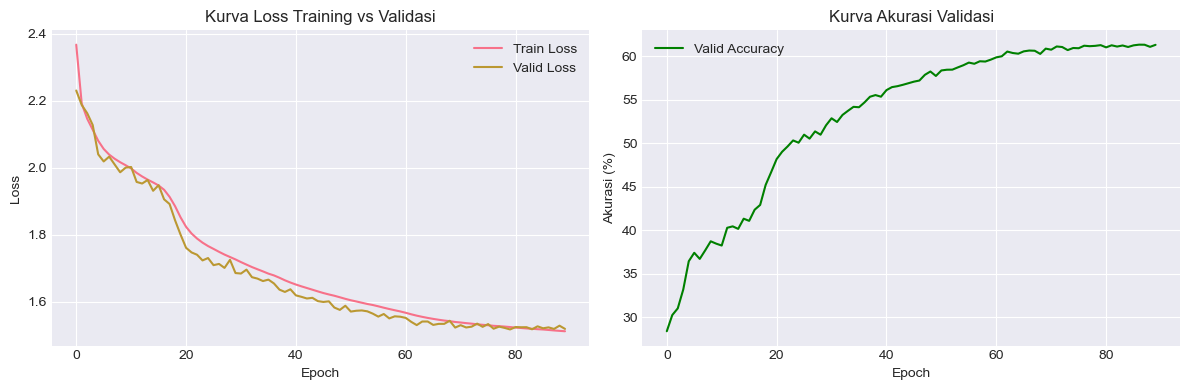


--- 2. Evaluasi pada Test Set ---


Mengevaluasi Test Set:   0%|          | 0/792 [00:00<?, ?batch/s]

Akurasi Keseluruhan pada Test Set: 61.32%

--- 3. Plotting Confusion Matrix ---


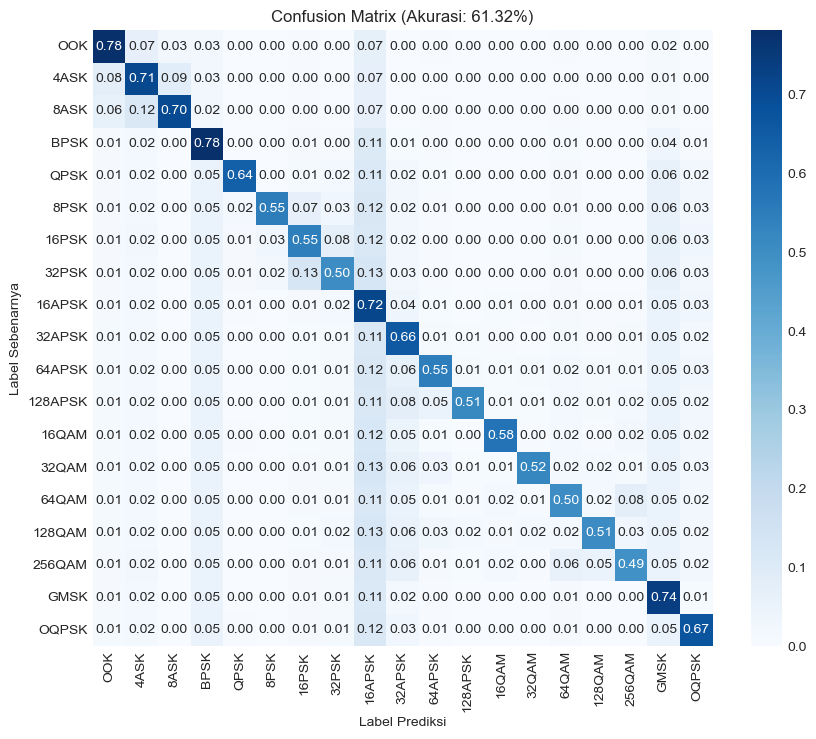


--- 4. Plotting Akurasi vs. SNR ---


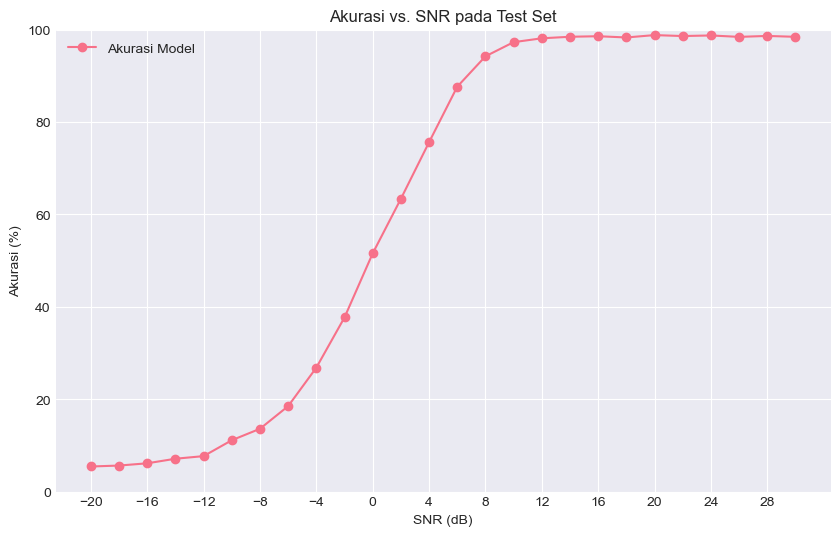

Membersihkan dataset...
🔒 Train dataset: File HDF5 ditutup
🔒 Valid dataset: File HDF5 ditutup
🔒 Test dataset: File HDF5 ditutup
✅ Selesai.
📁 Semua plot telah disimpan di direktori 'result/' dengan resolusi 600 DPI


In [157]:
import os

# Create result directory if it doesn't exist
os.makedirs('result', exist_ok=True)

print("--- 1. Plotting Kurva Pembelajaran ---")
plt.figure(figsize=(12, 4))
# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Valid Loss')
plt.title('Kurva Loss Training vs Validasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
# Plot Akurasi
plt.subplot(1, 2, 2)
plt.plot(history['val_acc'], label='Valid Accuracy', color='green')
plt.title('Kurva Akurasi Validasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('result/learning_curves.png', dpi=600, bbox_inches='tight')
plt.show()


print("\n--- 2. Evaluasi pada Test Set ---")
model.eval()
all_labels = []
all_predictions = []
all_snrs = []

test_pbar = tqdm(test_loader, desc="Mengevaluasi Test Set", unit="batch")

with torch.no_grad():
    for images, labels, snrs in test_pbar:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        all_snrs.extend(snrs.cpu().numpy())

# Konversi ke array NumPy
y_true = np.array(all_labels)
y_pred = np.array(all_predictions)
snrs_list = np.array(all_snrs)

# Hitung akurasi keseluruhan
overall_accuracy = accuracy_score(y_true, y_pred)
print(f"Akurasi Keseluruhan pada Test Set: {overall_accuracy * 100:.2f}%")


print("\n--- 3. Plotting Confusion Matrix ---")
# Buat label string dari label map
labels_str = list(label_map.keys())

cm = confusion_matrix(y_true, y_pred)
# Normalisasi CM
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=labels_str, yticklabels=labels_str)
plt.title(f'Confusion Matrix (Akurasi: {overall_accuracy*100:.2f}%)')
plt.ylabel('Label Sebenarnya')
plt.xlabel('Label Prediksi')
plt.savefig('result/confusion_matrix.png', dpi=600, bbox_inches='tight')
plt.show()


print("\n--- 4. Plotting Akurasi vs. SNR ---")
snr_values = np.unique(snrs_list)
acc_per_snr = []

for snr in snr_values:
    # Dapatkan indeks untuk SNR spesifik ini
    idx = (snrs_list == snr)
    if np.sum(idx) > 0: # Pastikan ada sampel
        snr_acc = accuracy_score(y_true[idx], y_pred[idx])
        acc_per_snr.append(snr_acc)
    else:
        acc_per_snr.append(np.nan) # Tambah NaN jika tidak ada sampel

plt.figure(figsize=(10, 6))
plt.plot(snr_values, [a * 100 for a in acc_per_snr], 'o-', label='Akurasi Model')
plt.title('Akurasi vs. SNR pada Test Set')
plt.xlabel('SNR (dB)')
plt.ylabel('Akurasi (%)')
plt.grid(True)
plt.xticks(snr_values[::2]) # Tampilkan label SNR setiap 4dB
plt.ylim(0, 100) # Akurasi dari 0% sampai 100%
plt.legend()
plt.savefig('result/accuracy_vs_snr.png', dpi=600, bbox_inches='tight')
plt.show()

# Terakhir, tutup file HDF5
print("Membersihkan dataset...")
train_dataset.close()
valid_dataset.close()
test_dataset.close()
print("✅ Selesai.")
print(f"📁 Semua plot telah disimpan di direktori 'result/' dengan resolusi 600 DPI")

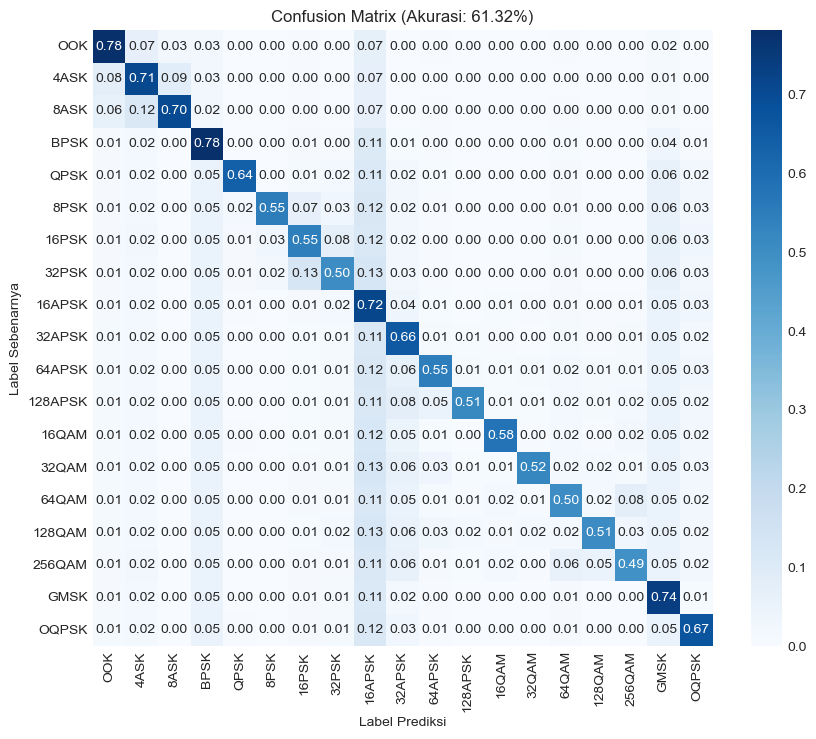

In [158]:
# --- Confusion Matrix Visualization ---
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Buat label string dari label_map
labels_str = list(label_map.keys())

# Hitung confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Normalisasi per baris (true label)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=labels_str, yticklabels=labels_str)
plt.title(f'Confusion Matrix (Akurasi: {overall_accuracy*100:.2f}%)')
plt.ylabel('Label Sebenarnya')
plt.xlabel('Label Prediksi')

# Simpan hasil ke folder result
os.makedirs('result', exist_ok=True)
plt.savefig('result/confusion_matrix.png', dpi=600, bbox_inches='tight')
plt.show()